# ERA5 composites of tracked convective cells 

**TO DO**

- select timeslots (e.g. 3 hour before initiation of system over the plateau, system from south is transported to plateau, no cloud system, dissipation)
- build composite 

- calculate wind shear, wind vectors, etc 
- plot characteristics 



In [1]:
## This function downloads ERA5 large-scale parameters for specified timepoint 

def download_era5_synoptic(year, month, day, hour, composite): 
    # input parameter: year,month, day, hour as str; composite is a str to describe composite feature (e.g. CS initiation)
    
    import cdsapi                                                                                           
    # Open a new Client instance                                                                            
    c = cdsapi.Client()         
    # output filename 
    file= 'composites/era5_'+ composite+'_'+ year + month+ day+ hour+ '.nc'
    # Send request (download data)                                                                     
    c.retrieve('reanalysis-era5-pressure-levels', {                                                           
            "product_type":   "reanalysis",                                                                 
            "format":         "netcdf",                                                                     
            "area":           "50.00/60.00/20.00/120.00",                                                   
            "variable":       [                                                                             
                'u_component_of_wind','v_component_of_wind', 'geopotential' , 'vertical_velocity', 'vorticity' , 'relative_humidity'                                                                                              
            ],                                                                                              
            "year":           [year],                                                      
            "month":          [month],                
            "day":            [day],                               
            "time":           [hour]                                                                                               
        }, file)                                                                

    print(file, 'downloaded and saved.')   
    

In [252]:
year = '2008'
month= '07'
day= '20'
hour='20'


download_era5_synoptic(year, month, day, hour, composite='tpvcase')                                     
                                      

2020-05-04 15:34:21,584 INFO Welcome to the CDS
2020-05-04 15:34:21,585 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-05-04 15:34:21,748 INFO Request is queued


KeyboardInterrupt: 

In [5]:
# read in dataframe with features/ tracks 
import pandas as pd 
import numpy as np

path = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_e.h5'
tracks_e = pd.read_hdf(path, 'table')

path = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_tp_n.h5'
tracks_n = pd.read_hdf(path, 'table')


path = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_e.h5'
tracks_E = pd.read_hdf(path, 'table')


path = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/Tracks_sr_n.h5'
tracks_N = pd.read_hdf(path, 'table')

## Choose situation 

In [22]:
tracks_e.sort_values(by = 'convective_precip', ascending = False)


initiation = pd.DataFrame(columns = tracks_e.columns)
majurity = pd.DataFrame(columns = tracks_e.columns)
dissipation = pd.DataFrame(columns = tracks_e.columns)
for cell in np.unique(tracks_e.cell.values):
    c= tracks_e[tracks_e.cell == cell]
    init = c.iloc[0,:]
    diss = c.iloc[-1,:]
    maj = c[c.convective_precip == np.nanmax(c.convective_precip.values)]
    initiation = initiation.append(init)
    majurity = majurity.append(maj)
    dissipation= dissipation.append(diss)
    

In [10]:
tp = initiation[initiation.tp_flag > 0]
init_tp = tp[tp.tp_flag == tp.ncells]

#maj_tp = majurity[majurity.tp_flag > 0]

In [26]:
maj_tp= pd.DataFrame(columns = tracks_e.columns )
diss_tp= pd.DataFrame(columns = tracks_e.columns )
for cell in init_tp.cell.values:
    maj_tp= maj_tp.append(majurity[majurity.cell == cell])
    diss_tp= diss_tp.append(dissipation[dissipation.cell == cell])
    

In [13]:
# subselect features and create time list for composites


years =np.array(())
months= np.array(())
days= np.array(())
hours= np.array(())

for t in pd.DatetimeIndex(maj_tp.time.values):
    years = np.append(years, t.year)
    months = np.append(months, t.month)
    days = np.append(days, t.day)
    hours = np.append(hours, t.hour)
    
years= years.astype('int')
months= months.astype('int')
days= days.astype('int')
hours= hours.astype('int')

! **Note: MCS which form over the TP have precipitate most at the edges (in the downstream regions, and not over the plateau )**

In [18]:
## Import elevation file for 3000 m boundary 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)
lon = elevations.lon.values
lat= elevations.lat.values

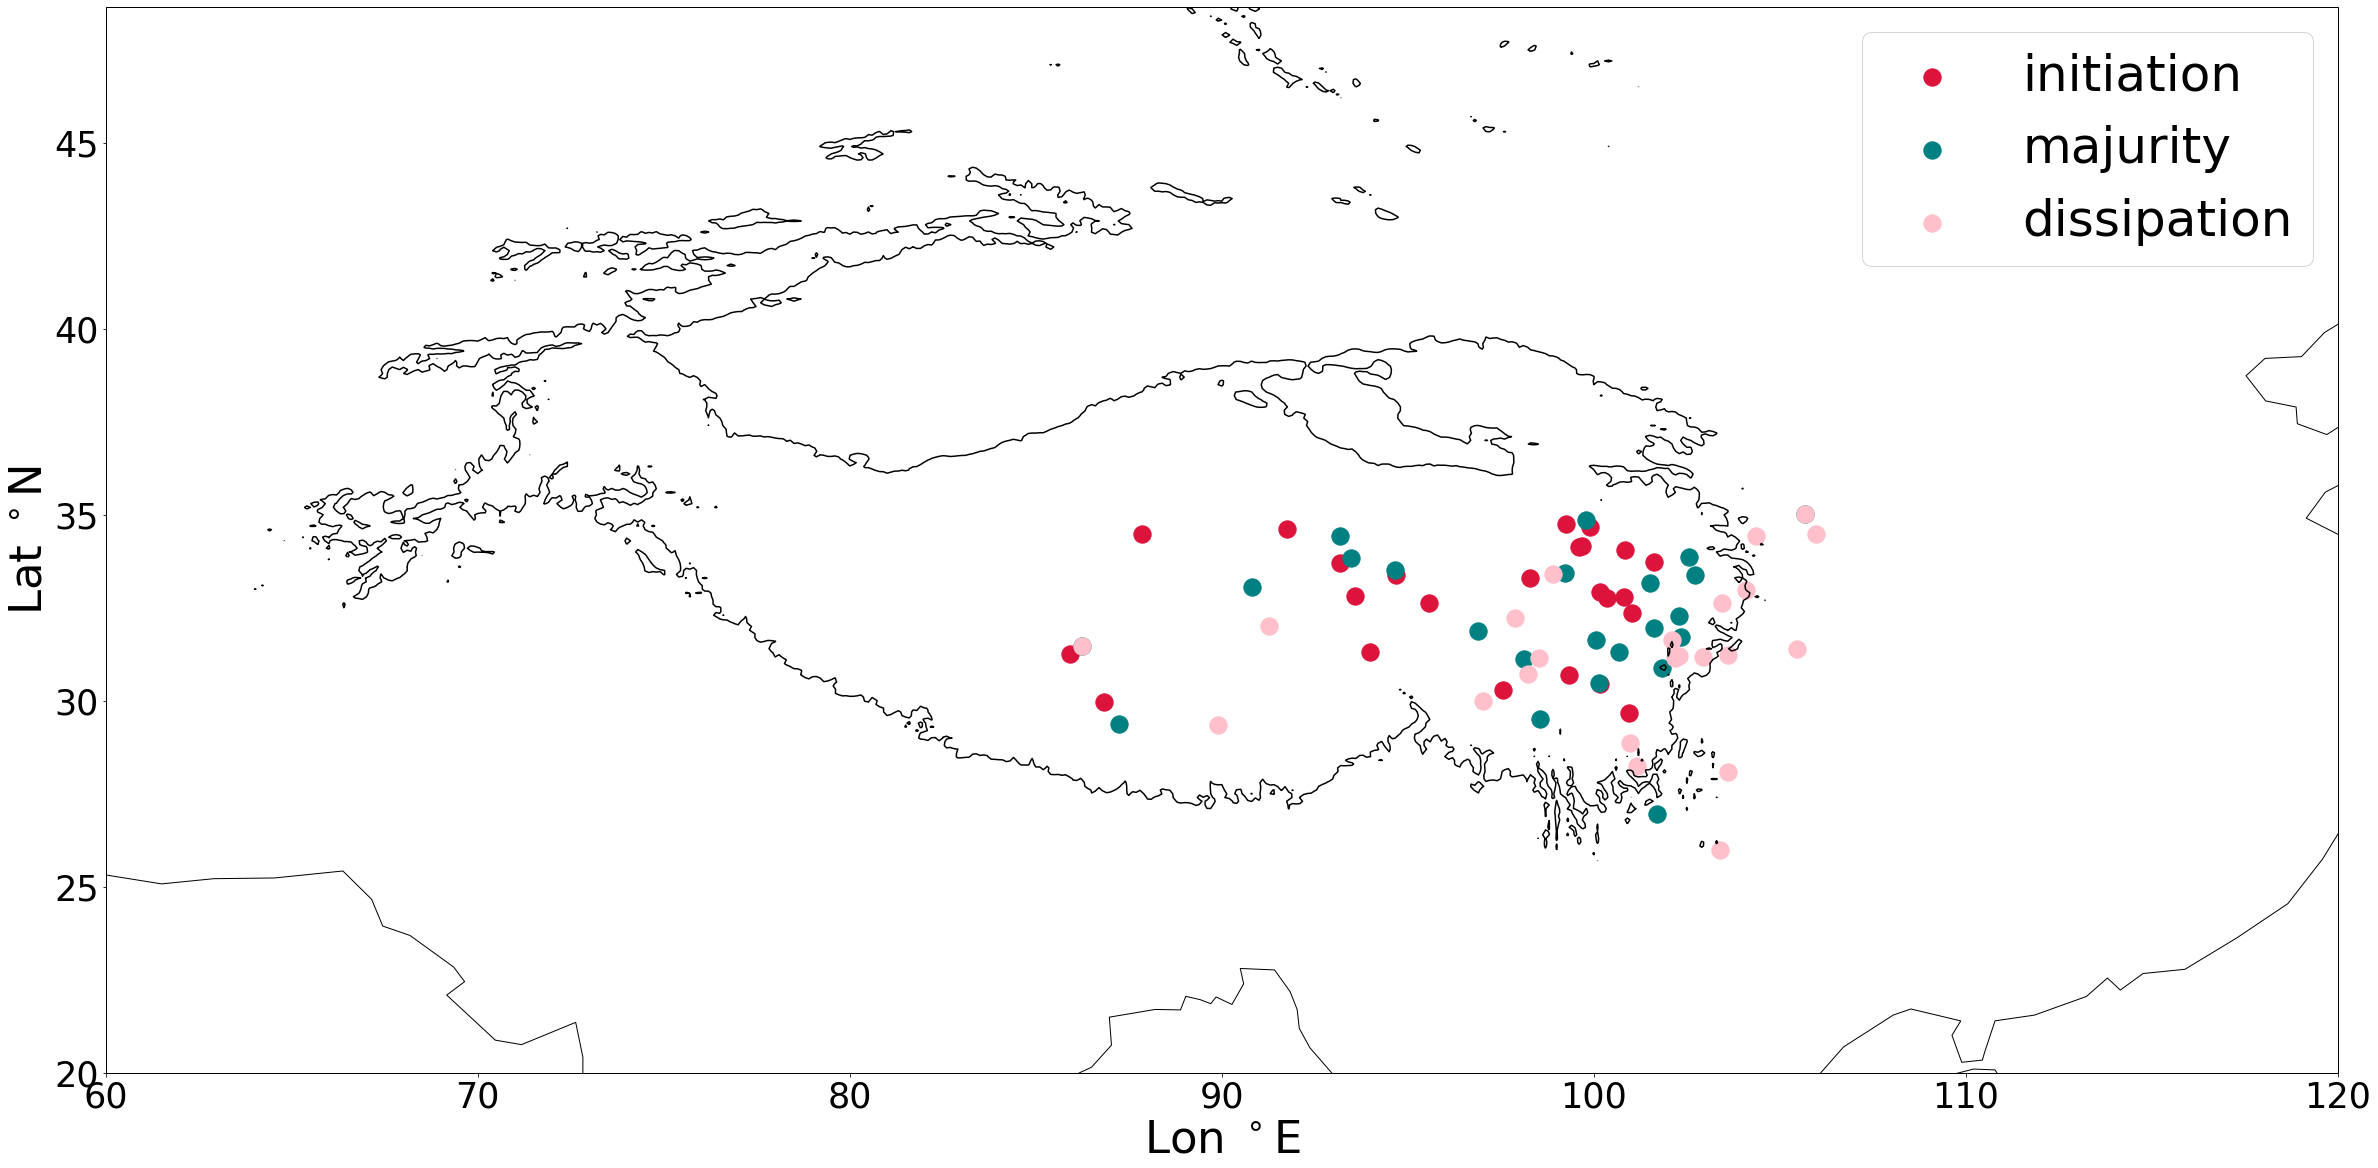

In [29]:
## track density plot 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs

plt.figure(figsize=(40,20))
xlabels=[60,70,80,90,100,110,120]
ylabels= [20,30,40]
# markersize 
s = 300

# Tracks TP eastwards 
ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(elevations.lon.values),np.nanmax(elevations.lon.values),20,45])
ax1.scatter(init_tp.longitude.values, init_tp.latitude.values,  color='crimson',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'initiation')

ax1.scatter(maj_tp.longitude.values, maj_tp.latitude.values,  color='teal',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'majurity')

ax1.scatter(diss_tp.longitude.values, diss_tp.latitude.values,  color='pink',marker='o', s = s, transform=ccrs.PlateCarree(),label= 'dissipation')


ax1.coastlines()
# 3000 m boundary 
ax1.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')
# axis labels 
ax1.legend(fontsize= 50)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=45)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=45)



plt.rc('xtick', labelsize=35) 
plt.rc('ytick', labelsize=35) 
plt.savefig('plots/tp_initiation.png')
plt.show()


## Download composites : example

In [16]:
for i,year in enumerate(years):
    year = str(year)
    month= str(months[i])
    day= str(days[i])
    hour= str(hours[i])
    print(year, month, day, hour)
    download_era5_synoptic(year, month, day, hour, composite= 'tp_majure')      
    

2000 6 9 11


2020-05-04 15:38:30,972 INFO Welcome to the CDS
2020-05-04 15:38:30,973 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-05-04 15:38:31,165 INFO Request is queued
2020-05-04 16:56:56,570 INFO Request is completed
2020-05-04 16:56:56,571 INFO Downloading http://136.156.133.37/cache-compute-0011/cache/data1/adaptor.mars.internal-1588604200.1272888-4035-12-563f32fb-0ae4-443c-a369-8a8ddca9b6cd.nc to composites/era5_tp_majure_20006911.nc (2M)
2020-05-04 16:56:57,168 INFO Download rate 3.4M/s   
2020-05-04 16:56:57,462 INFO Welcome to the CDS
2020-05-04 16:56:57,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_tp_majure_20006911.nc downloaded and saved.
2005 7 4 10


2020-05-04 16:56:57,749 INFO Request is queued
2020-05-04 17:31:20,525 INFO Request is completed
2020-05-04 17:31:20,525 INFO Downloading http://136.156.133.39/cache-compute-0012/cache/data9/adaptor.mars.internal-1588606206.9016588-31620-15-f12f48aa-3977-4127-8d4f-36acff76a21e.nc to composites/era5_tp_majure_20057410.nc (2M)
2020-05-04 17:31:20,953 INFO Download rate 4.7M/s   


composites/era5_tp_majure_20057410.nc downloaded and saved.
2011 6 20 15


2020-05-04 17:31:21,593 INFO Welcome to the CDS
2020-05-04 17:31:21,594 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-05-04 17:31:21,890 INFO Request is queued
2020-05-04 17:45:42,177 INFO Request is completed
2020-05-04 17:45:42,178 INFO Downloading http://136.156.133.25/cache-compute-0008/cache/data8/adaptor.mars.internal-1588607076.340657-25776-13-3bf4f9b9-0f7a-4417-ae1d-8a0377908b36.nc to composites/era5_tp_majure_201162015.nc (2M)
2020-05-04 17:45:42,659 INFO Download rate 4.2M/s   
2020-05-04 17:45:42,879 INFO Welcome to the CDS
2020-05-04 17:45:42,880 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_tp_majure_201162015.nc downloaded and saved.
2011 7 2 16


2020-05-04 17:45:43,196 INFO Request is queued
2020-05-04 18:18:05,033 INFO Request is completed
2020-05-04 18:18:05,033 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data8/adaptor.mars.internal-1588609035.5850158-5426-1-3356daeb-f754-4b7f-aff7-534c45fa812f.nc to composites/era5_tp_majure_20117216.nc (2M)
2020-05-04 18:18:05,420 INFO Download rate 5.2M/s   
2020-05-04 18:18:05,789 INFO Welcome to the CDS
2020-05-04 18:18:05,790 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels


composites/era5_tp_majure_20117216.nc downloaded and saved.
2018 7 1 10


2020-05-04 18:18:06,067 INFO Request is queued
2020-05-04 18:40:58,188 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 0 of 500
2020-05-04 18:40:58,189 WARNING Retrying in 120 seconds
2020-05-04 18:42:58,289 INFO Retrying now...
2020-05-04 18:43:28,416 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 1 of 500
2020-05-04 18:43:28,416 WARNING Retrying in 120 seconds
2020-05-04 18:45:28,480 INFO Retrying now...
2020-05-04 18:45:59,435 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 2 of 500
2020-05-04 18:45:59,435 WARNING Retrying in 120 seconds
2020-05-04 18:47:59,536 INFO Retrying now...
2020-05-04 18:48:29,659 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 3 of 500
2020-05-04 18:48:29,659 WARNING Retrying in 120 seconds
2020-05-04 18:50:29,703 INFO Retrying now...
2020-05-04 18:50:59,825 WARNING Recovering from HTTP error [500 Internal Server Error], attemps 4 of 500
2020-05-04 18:50:59,826 

2020-05-04 19:30:34,833 ERROR       return requester.make_request(request)
2020-05-04 19:30:34,833 ERROR     File "/opt/cds/cdsinf/python/lib/cdsclient/requesterchain.py", line 274, in make_request
2020-05-04 19:30:34,834 ERROR       result = self.next_in_chain.make_request(request)
2020-05-04 19:30:34,834 ERROR     File "/opt/cds/cdsinf/python/lib/cdsclient/brokerclient.py", line 1179, in make_request
2020-05-04 19:30:34,834 ERROR       return self._make_v2_request(request)
2020-05-04 19:30:34,834 ERROR     File "/opt/cds/cdsinf/python/lib/cdsclient/brokerclient.py", line 1302, in _make_v2_request
2020-05-04 19:30:34,835 ERROR       None)
2020-05-04 19:30:34,835 ERROR     File "/opt/cds/cdsinf/python/lib/cdsclient/brokerclient.py", line 1153, in _make_json_request
2020-05-04 19:30:34,835 ERROR       "http://copernicus-climate.eu/exc/broker-404"))
2020-05-04 19:30:34,835 ERROR   cdsclient.exceptions.BrokerError: Not found


Exception: Resource reanalysis-era5-pressure-levels not found. Not found.

## Visualizing large-scale composites 

In [193]:
import xarray 

f= 'composites/era5_tpvcase_2008072018.nc'
f= 'composites/dissipation.nc'
f= 'composites/majurity.nc'
f= 'composites/genesis.nc'
c= xarray.open_dataset(f)
#print(c)

# get data variables 
uwind= c.u.values
vwind= c.v.values
windspeed = (uwind ** 2 + vwind ** 2) ** 0.5
w= c.w.values
vorticity= c.vo.values
rh= c.r.values
geopotential = c.z.values
lats= c.latitude.values
lons = c.longitude.values
# convert coords to 2d array 
x,y = np.meshgrid(lons, lats)


<Figure size 1080x432 with 0 Axes>

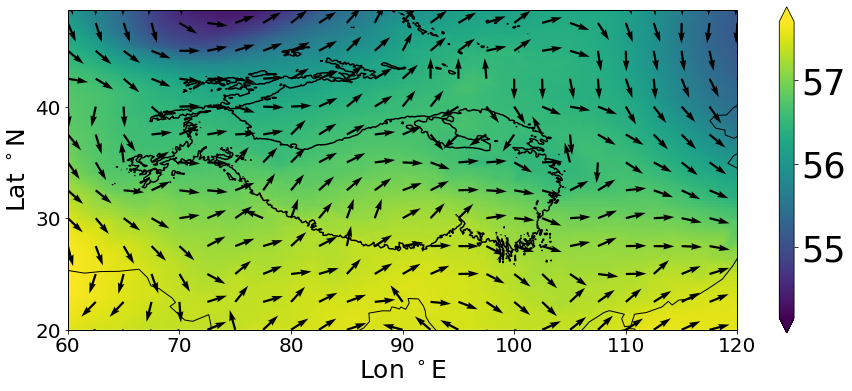

In [200]:
import quiver
import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np


idx_850hpa =1
idx_500hpa= 3
idx_300hpa= 5
level = 3

plt.figure(figsize= (15,6))

plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([np.nanmin(lons),np.nanmax(lons),20,45])


# 3000 m boundary 
plt.contour(lon,lat, elevations.data.T, [3000], cmap = 'Greys_r')

# Plot the wind speed as a contour plot
cmap=plt.cm.viridis
m = plt.pcolormesh(lons, lats,geopotential[0,3,:, :]/1000, cmap = cmap)
#m = plt.pcolormesh(lons, lats,vorticity[0,3,:, :] , cmap = cmap, vmin = -0.0001, vmax = 0.0002 )
#m = plt.pcolormesh(lons, lats,rh[0,2,:, :], cmap = cmap)


# Normalise the data for uniform arrow size
u_norm = uwind[0,level,:, :]/ np.sqrt(uwind[0,level,:, :] ** 2.0 + vwind[0,3,:, :] ** 2.0)
v_norm = vwind[0,level,:, :] / np.sqrt(uwind[0,level,:, :] ** 2.0 + vwind[0,3,:, :] ** 2.0)

# Plot wind vectors 
skip  =(slice(None,None,10),slice(None,None,10))
plt.quiver(x[skip],y[skip],u_norm[skip], v_norm[skip], color ='k', transform= ccrs.PlateCarree())


# colorbar 
cbar= plt.colorbar(m, extend = 'both')
#cbar.set_label('geopotential (km$^2$ s$^{-2}$ )', fontsize = 15)

# axes 
xlabels=[60,70,80,90,100,110,120]
ylabels= [20,30,40]
plt.xticks(xlabels, xlabels, fontsize=20)
plt.yticks(ylabels,ylabels, fontsize=20)
plt.xlabel('Lon $^\circ$E',  fontsize=25)
plt.ylabel('Lat $^\circ$N',  fontsize=25)

ax.coastlines()
plt.savefig('init_tp_500hpawind.png')
plt.show()

**Notes**

- variables for cases: vorticity, moisture, vertical velocity 
- variables for composites: upper-level wind and geopotential 